In [ ]:
# @title Import Libraries
import os
import numpy as np
import pandas as pd
import cv2
from IPython.display import Image, display
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import callbacks
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
import matplotlib.image as img
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [ ]:
# @title Extract zip folders
import zipfile

# Open the ZIP file
with zipfile.ZipFile('/content/Dataset.zip', "r") as zip_ref:
    # Extract all contents to the specified directory
    zip_ref.extractall("target_dir")

In [ ]:
# @title Make Dataframe
tumor_dir='/content/target_dir/yes'
healthy_dir='/content/target_dir/no'

filepaths = []
labels= []
dict_list = [tumor_dir, healthy_dir]
for i, j in enumerate(dict_list):
    flist=os.listdir(j)
    for f in flist:
        fpath=os.path.join(j,f)
        filepaths.append(fpath)
        if i==0:
          labels.append('present')
        else:
          labels.append('absent')

Fseries = pd.Series(filepaths, name="filepaths")
Lseries = pd.Series(labels, name="labels")
tumor_data = pd.concat([Fseries,Lseries], axis=1)
tumor_df = pd.DataFrame(tumor_data)
print(tumor_df.head())
print(tumor_df["labels"].value_counts())

                          filepaths   labels
0  /content/target_dir/yes/Y168.jpg  present
1    /content/target_dir/yes/Y4.jpg  present
2   /content/target_dir/yes/Y67.JPG  present
3   /content/target_dir/yes/Y28.jpg  present
4   /content/target_dir/yes/Y95.jpg  present
present    155
absent      98
Name: labels, dtype: int64


In [ ]:
tumor_df.shape

(253, 2)

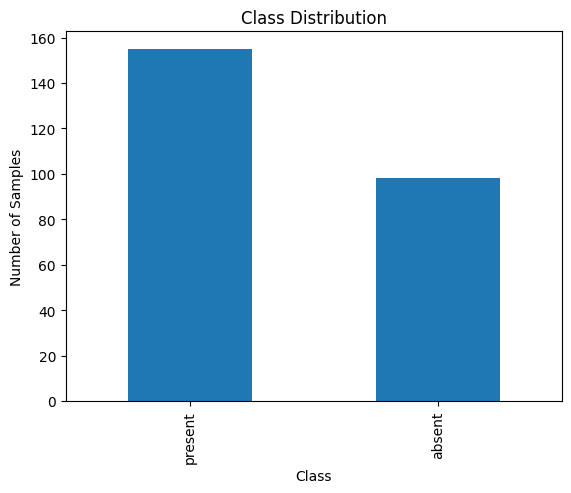

Class Proportions:
present    0.612648
absent     0.387352
Name: labels, dtype: float64


In [ ]:
# @title Check for class imbalance
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame containing class labels
class_distribution = tumor_df['labels'].value_counts()

# Visualize the class distribution
class_distribution.plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.show()

# Calculate class proportions
class_proportions = class_distribution / class_distribution.sum()

# Print class proportions
print("Class Proportions:")
print(class_proportions)

In [ ]:
# @title Make a new directory for classifying into training and validation sets
import os
import shutil

# Path to your original directory containing all images
original_dir = '/content/target_dir'

# Path to a new directory where you'll organize the images for Keras
keras_dir = 'new_dir/'

# Create subdirectories for 'train' and 'validation'
train_dir = os.path.join(keras_dir, 'train')
os.makedirs(train_dir, exist_ok=True)
validation_dir = os.path.join(keras_dir, 'validation')
os.makedirs(validation_dir, exist_ok=True)

# Function to move images to appropriate directories
def move_images_to_dir(original_dir, target_dir):
    for filename in os.listdir(original_dir):
        if filename.endswith('.jpg'):
            class_name = filename.split('_')[0]  # Extract class label from filename
            class_dir = os.path.join(target_dir, class_name)
            os.makedirs(class_dir, exist_ok=True)
            shutil.copy(os.path.join(original_dir, filename), os.path.join(class_dir, filename))

# Split ratio for train-validation split
split_ratio = 0.8

# Move images to train directory
move_images_to_dir(original_dir, train_dir)

# Move remaining images to validation directory
move_images_to_dir(original_dir, validation_dir)

In [ ]:
# @title Move images to train and validation sets
import os
import shutil
import random

def copy_images_with_subdirectories(source_dir, dest_dir):
    os.makedirs(dest_dir, exist_ok=True)
    for subdir in os.listdir(source_dir):
        sub_source_dir = os.path.join(source_dir, subdir)
        sub_dest_dir = os.path.join(dest_dir, subdir)
        os.makedirs(sub_dest_dir, exist_ok=True)
        for file in os.listdir(sub_source_dir):
            source_path = os.path.join(sub_source_dir, file)
            dest_path = os.path.join(sub_dest_dir, file)
            shutil.copy(source_path, dest_path)

# Define the directory containing your original images
original_data_dir = '/content/target_dir'

# Define the directory where you want to store your training and validation data
base_dir = '/content/new_dir'
os.makedirs(base_dir, exist_ok=True)

# Define the subdirectories for train and validation data
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Define the ratio of data to use for training
train_ratio = 0.8  # 80% for training, 20% for validation

# List all the subdirectories in the original data directory
subdirs = os.listdir(original_data_dir)

# Shuffle the subdirectories to ensure randomness
random.shuffle(subdirs)

# Split the subdirectories into training and validation sets
train_subdirs = subdirs[:int(len(subdirs) * train_ratio)]
validation_subdirs = subdirs[int(len(subdirs) * train_ratio):]

# Copy images to the train directory
copy_images_with_subdirectories(original_data_dir, train_dir)

# Copy images to the validation directory
copy_images_with_subdirectories(original_data_dir, validation_dir)

Preprocessing of data begins here..
1. Data augmentation and rescaling
2. Grey scale conversion and guassian blurring
3. Image resizing

In [ ]:
# @title Data augmentation and rescaling
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight

# Define directories
train_dir = '/content/new_dir/train'
validation_dir = '/content/new_dir/validation'

# Define image data generators with data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validation data generator (only rescaling)
validation_datagen = ImageDataGenerator(rescale=1./255)

# Define batch size
batch_size = 32

# Create train and validation data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='binary'
)

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(train_generator.classes), y=train_generator.classes)


# Define and compile the model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(lr=1e-4),
              metrics=['accuracy'])

# Train the model with class weights
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    class_weight=dict(enumerate(class_weights))
)

Found 253 images belonging to 2 classes.
Found 253 images belonging to 2 classes.


Epoch 1/10
7/7 [==============================] - 19s 3s/step - loss: 2.0211 - accuracy: 0.4887 - val_loss: 0.6957 - val_accuracy: 0.3973
Epoch 2/10
7/7 [==============================] - 16s 2s/step - loss: 0.6876 - accuracy: 0.5430 - val_loss: 0.6986 - val_accuracy: 0.3929
Epoch 3/10
7/7 [==============================] - 17s 2s/step - loss: 0.6773 - accuracy: 0.6071 - val_loss: 0.6108 - val_accuracy: 0.6473
Epoch 4/10
7/7 [==============================] - 23s 3s/step - loss: 0.6617 - accuracy: 0.6244 - val_loss: 0.6986 - val_accuracy: 0.3839
Epoch 5/10
7/7 [==============================] - 18s 2s/step - loss: 0.6703 - accuracy: 0.6161 - val_loss: 0.7374 - val_accuracy: 0.4598
Epoch 6/10
7/7 [==============================] - 18s 3s/step - loss: 0.6469 - accuracy: 0.6384 - val_loss: 1.4144 - val_accuracy: 0.3973
Epoch 7/10
7/7 [==============================] - 18s 3s/step - loss: 0.7310 - accuracy: 0.6161 - val_loss: 0.5659 - val_accuracy: 0.7634
Epoch 8/10
7/7 [==================

In [ ]:
# @title Grey scale conversion and guassian blurring
import os
import cv2

# Function to process images in a directory
def process_images_in_directory(directory, output_directory):
    os.makedirs(output_directory, exist_ok=True)

    # Iterate through all files in the directory
    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)
        if os.path.isdir(file_path):
            # If the file is a directory, recursively process images in it
            sub_output_directory = os.path.join(output_directory, filename)
            process_images_in_directory(file_path, sub_output_directory)
        elif filename.endswith('.jpg') or filename.endswith('.png'):
            # Load the image
            image = cv2.imread(file_path)

            # Convert the image to grayscale
            gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

            # Apply Gaussian blur
            blurred_image = cv2.GaussianBlur(gray_image, (5, 5), 0)

            # Write the processed image to the output directory
            output_path = os.path.join(output_directory, filename)
            cv2.imwrite(output_path, blurred_image)

# Directory containing the main directory with subdirectories
main_directory = '/content/new_dir'

# Output directory for processed images
output_directory = 'processed_images/'

# Process images in the main directory
process_images_in_directory(main_directory, output_directory)

In [ ]:
# @title Image resizing
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight

# Define directories
train_dir = '/content/processed_images/train'
validation_dir = '/content/processed_images/validation'

# Define image data generators with data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validation data generator (only rescaling)
validation_datagen = ImageDataGenerator(rescale=1./255)

# Define batch size
batch_size = 32

# Create train and validation data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='binary'
)

Found 173 images belonging to 2 classes.
Found 173 images belonging to 2 classes.


In [ ]:
# @title Segmentation
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, concatenate

# Define U-Net architecture
def unet(input_shape=(256, 256, 1)):
    inputs = Input(input_shape)

    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    # Bottleneck
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)
    drop5 = Dropout(0.5)(conv5)

    # Decoder
    up6 = Conv2DTranspose(512, 2, strides=(2, 2), activation='relu', padding='same')(drop5)
    merge6 = concatenate([drop4, up6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = Conv2DTranspose(256, 2, strides=(2, 2), activation='relu', padding='same')(conv6)
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = Conv2DTranspose(128, 2, strides=(2, 2), activation='relu', padding='same')(conv7)
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = Conv2DTranspose(64, 2, strides=(2, 2), activation='relu', padding='same')(conv8)
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)

    # Output layer
    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=conv10)
    return model

# Define loss function (dice coefficient) for segmentation
def dice_coefficient(y_true, y_pred, smooth=1):
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

# Compile the model
model = unet()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coefficient])

In [ ]:
train_images, test_images=train_test_split(tumor_df, test_size=0.3, random_state=42)
train_set, val_set=train_test_split(tumor_df, test_size=0.2, random_state=42)

In [ ]:
print(train_set.shape)
print(val_set.shape)
print(train_images.shape)
print(test_images.shape)

(202, 2)
(51, 2)
(177, 2)
(76, 2)


In [ ]:
# @title MobileNetv2 Architechture
image_gen = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)
train=image_gen.flow_from_dataframe(dataframe=train_set, x_col='filepaths',y_col='labels',
                                    target_size=(244,244),
                                    color_mode='rgb',
                                    class_mode="categorical",
                                    batch_size=32,
                                    shuffle=False)

test=image_gen.flow_from_dataframe(dataframe=test_images, x_col='filepaths',y_col='labels',
                                    target_size=(244,244),
                                    color_mode='rgb',
                                    class_mode="categorical",
                                    batch_size=32,
                                    shuffle=False)
val=image_gen.flow_from_dataframe(dataframe=val_set, x_col='filepaths',y_col='labels',
                                    target_size=(244,244),
                                    color_mode='rgb',
                                    class_mode="categorical",
                                    batch_size=32,
                                    shuffle=False)

Found 202 validated image filenames belonging to 2 classes.
Found 76 validated image filenames belonging to 2 classes.
Found 51 validated image filenames belonging to 2 classes.


In [ ]:
# Accessing class indices of train_generator
classes = list(train.class_indices.keys())
print(classes)

['absent', 'present']


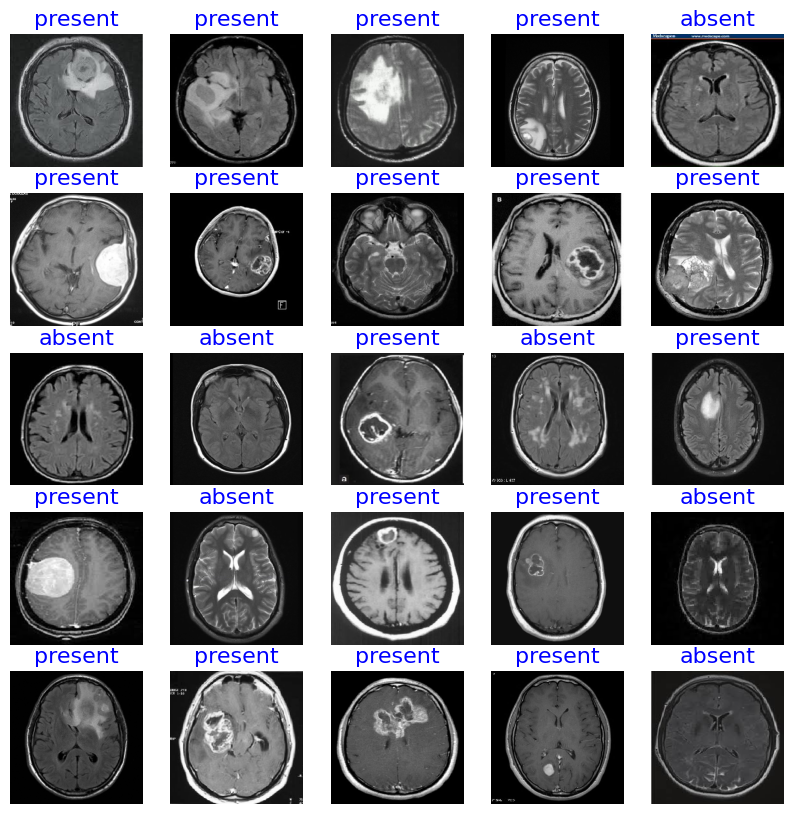

In [ ]:
def show_brain_images(image_gen):
    test_dict = test.class_indices
    classes = list(test_dict.keys())
    images, labels=next(image_gen) # get a sample batch from the generator
    plt.figure(figsize=(10,10))
    length = len(labels)
    r=25
    for i in range(r):
        plt.subplot(5,5,i+1)
        image=(images[i]+1)/2 #scale images between 0 and 1
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color="blue",fontsize=16)
        plt.axis('off')
    plt.show()
show_brain_images(train)

In [ ]:
model=Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,2),strides=(1,1),activation='relu',padding='valid',input_shape=(244,244,3)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(rate=0.32))
model.add(Dense(64, activation='relu'))

model.add(Dense(2, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 242, 243, 32)      608       
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 121, 121, 32)      0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 468512)            0         
                                                                 
 dense_2 (Dense)             (None, 128)               59969664  
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                      

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
History=model.fit(train, validation_data=val, epochs=20, verbose=1, callbacks=[early_stopping])

Epoch 1/20
7/7 [==============================] - 19s 2s/step - loss: 6.4310 - accuracy: 0.5495 - val_loss: 9.2415 - val_accuracy: 0.5294
Epoch 2/20
7/7 [==============================] - 15s 2s/step - loss: 4.0428 - accuracy: 0.6485 - val_loss: 1.1106 - val_accuracy: 0.7255
Epoch 3/20
7/7 [==============================] - 15s 2s/step - loss: 1.6618 - accuracy: 0.6980 - val_loss: 0.9874 - val_accuracy: 0.6275
Epoch 4/20
7/7 [==============================] - 23s 4s/step - loss: 0.6069 - accuracy: 0.7921 - val_loss: 0.5575 - val_accuracy: 0.8235
Epoch 5/20
7/7 [==============================] - 15s 2s/step - loss: 0.4401 - accuracy: 0.8465 - val_loss: 0.4988 - val_accuracy: 0.7451
Epoch 6/20
7/7 [==============================] - 15s 2s/step - loss: 0.2888 - accuracy: 0.9109 - val_loss: 0.5039 - val_accuracy: 0.7647
Epoch 7/20
7/7 [==============================] - 15s 2s/step - loss: 0.2110 - accuracy: 0.9356 - val_loss: 0.4651 - val_accuracy: 0.8235
Epoch 8/20
7/7 [==================

Text(0.5, 1.0, 'Training and Validation Accuracy')

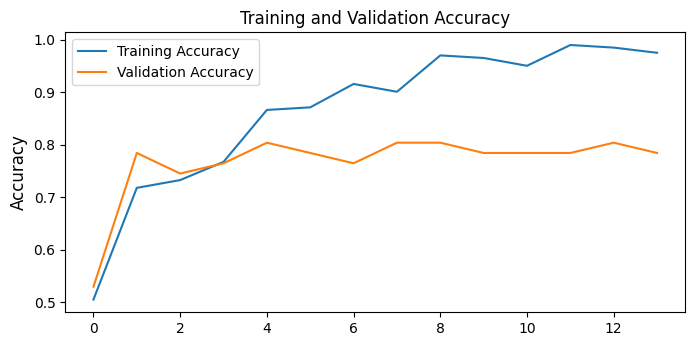

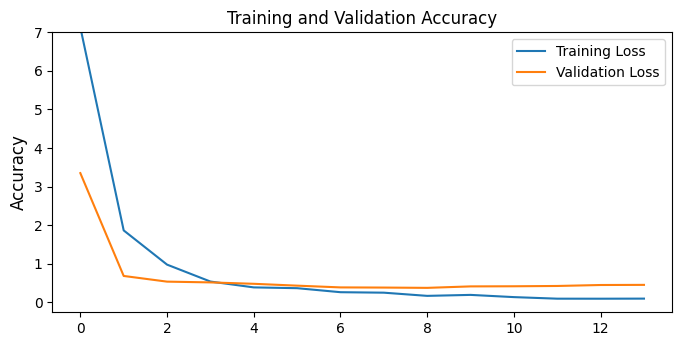

In [ ]:
#Accuracy curves
acc=History.history["accuracy"]
val_acc=History.history["val_accuracy"]

loss=History.history["loss"]
val_loss=History.history["val_loss"]

plt.figure(figsize=(8,8))
plt.subplot(2,1,1)

plt.plot(acc,label="Training Accuracy")
plt.plot(val_acc, label="Validation Accuracy")

plt.legend()
plt.ylabel("Accuracy", fontsize=12)
plt.title("Training and Validation Accuracy", fontsize=12)

#Loss Curves
plt.figure(figsize=(8,8))
plt.subplot(2,1,1)

plt.plot(loss,label="Training Loss")
plt.plot(val_loss, label="Validation Loss")

plt.legend()
plt.ylim([min(plt.ylim()),7])
plt.ylabel("Accuracy", fontsize=12)
plt.title("Training and Validation Accuracy", fontsize=12)

In [ ]:
model.evaluate(test, verbose=1)
pred=model.predict(test)
pred=np.argmax(pred, axis=1)

labels=(train.class_indices)
labels=dict((v,k) for k,v in labels.items())
pred2=[labels[k] for k in pred]

3/3 [==============================] - 2s 479ms/step


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
y_test=test_images.labels
print(classification_report(y_test,pred2))
acc_1 = accuracy_score(y_test, pred2)*100
print("\nAccuracy of the model:",acc_1)

              precision    recall  f1-score   support

      absent       0.89      0.77      0.83        31
     present       0.86      0.93      0.89        45

    accuracy                           0.87        76
   macro avg       0.87      0.85      0.86        76
weighted avg       0.87      0.87      0.87        76


Accuracy of the model: 86.8421052631579


<Axes: >

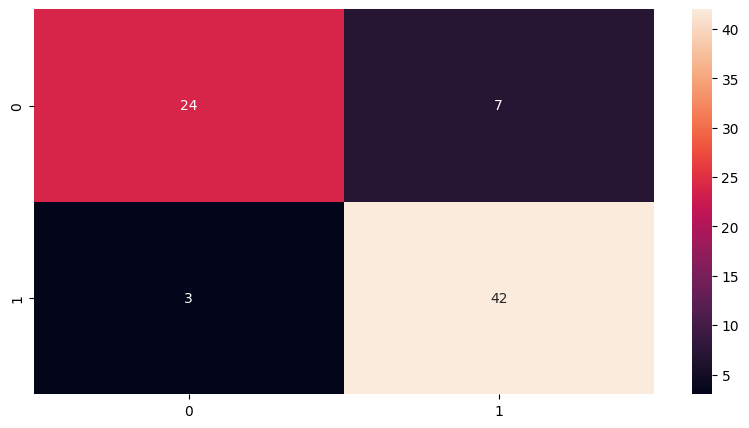

In [ ]:
import seaborn as sns
plt.figure(figsize = (10,5))
cm = confusion_matrix(y_test, pred2)
sns.heatmap(cm, annot=True, fmt = 'g')

In [ ]:
# @title EfficientNet Architechture
image_gen = ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet.preprocess_input)
train=image_gen.flow_from_dataframe(dataframe=train_set, x_col='filepaths',y_col='labels',
                                    target_size=(244,244),
                                    color_mode='rgb',
                                    class_mode="categorical",
                                    batch_size=32,
                                    shuffle=False)

test=image_gen.flow_from_dataframe(dataframe=test_images, x_col='filepaths',y_col='labels',
                                    target_size=(244,244),
                                    color_mode='rgb',
                                    class_mode="categorical",
                                    batch_size=32,
                                    shuffle=False)
val=image_gen.flow_from_dataframe(dataframe=val_set, x_col='filepaths',y_col='labels',
                                    target_size=(244,244),
                                    color_mode='rgb',
                                    class_mode="categorical",
                                    batch_size=32,
                                    shuffle=False)

Found 202 validated image filenames belonging to 2 classes.
Found 76 validated image filenames belonging to 2 classes.
Found 51 validated image filenames belonging to 2 classes.


In [ ]:
model=Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,2),strides=(1,1),activation='relu',padding='valid',input_shape=(244,244,3)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(rate=0.32))
model.add(Dense(64, activation='relu'))

model.add(Dense(2, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_23 (Conv2D)          (None, 242, 243, 32)      608       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 121, 121, 32)      0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 468512)            0         
                                                                 
 dense_5 (Dense)             (None, 128)               59969664  
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                      

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
History=model.fit(train, validation_data=val, epochs=20, verbose=1, callbacks=[early_stopping])

Epoch 1/20
7/7 [==============================] - 25s 4s/step - loss: 1440.5010 - accuracy: 0.5446 - val_loss: 1207.4658 - val_accuracy: 0.5686
Epoch 2/20
7/7 [==============================] - 15s 2s/step - loss: 857.8401 - accuracy: 0.7129 - val_loss: 185.1013 - val_accuracy: 0.8039
Epoch 3/20
7/7 [==============================] - 15s 2s/step - loss: 509.4367 - accuracy: 0.6584 - val_loss: 163.0697 - val_accuracy: 0.6667
Epoch 4/20
7/7 [==============================] - 15s 2s/step - loss: 162.9401 - accuracy: 0.7426 - val_loss: 73.5179 - val_accuracy: 0.7255
Epoch 5/20
7/7 [==============================] - 15s 2s/step - loss: 113.9446 - accuracy: 0.7525 - val_loss: 46.7742 - val_accuracy: 0.8235
Epoch 6/20
7/7 [==============================] - 15s 2s/step - loss: 51.3323 - accuracy: 0.7871 - val_loss: 34.5104 - val_accuracy: 0.7451
Epoch 7/20
7/7 [==============================] - 15s 2s/step - loss: 26.6527 - accuracy: 0.8663 - val_loss: 19.7111 - val_accuracy: 0.7843
Epoch 8/20

Text(0.5, 1.0, 'Training and Validation Accuracy')

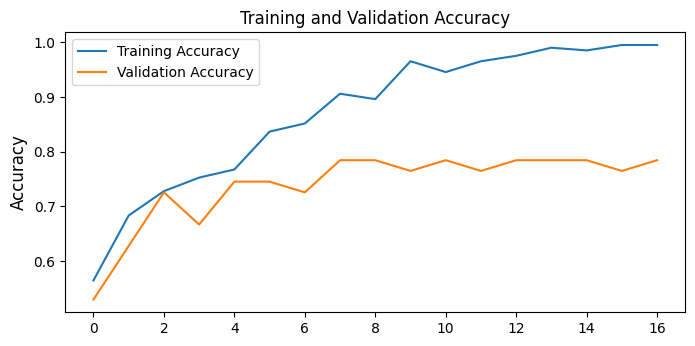

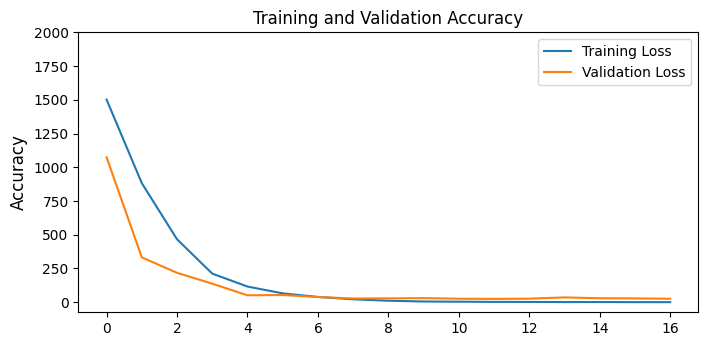

In [ ]:
#Accuracy curves
acc=History.history["accuracy"]
val_acc=History.history["val_accuracy"]

loss=History.history["loss"]
val_loss=History.history["val_loss"]

plt.figure(figsize=(8,8))
plt.subplot(2,1,1)

plt.plot(acc,label="Training Accuracy")
plt.plot(val_acc, label="Validation Accuracy")

plt.legend()
plt.ylabel("Accuracy", fontsize=12)
plt.title("Training and Validation Accuracy", fontsize=12)

#Loss curves
plt.figure(figsize=(8,8))
plt.subplot(2,1,1)

plt.plot(loss,label="Training Loss")
plt.plot(val_loss, label="Validation Loss")

plt.legend()
plt.ylim([min(plt.ylim()),2000])
plt.ylabel("Accuracy", fontsize=12)
plt.title("Training and Validation Accuracy", fontsize=12)

In [ ]:
model.evaluate(test, verbose=1)
pred=model.predict(test)
pred=np.argmax(pred, axis=1)

labels=(train.class_indices)
labels=dict((v,k) for k,v in labels.items())
pred2=[labels[k] for k in pred]

3/3 [==============================] - 1s 284ms/step


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
y_test=test_images.labels
print(classification_report(y_test,pred2))
acc_2 = accuracy_score(y_test, pred2)*100
print("\nAccuracy of the model:",acc_2)

              precision    recall  f1-score   support

      absent       0.81      0.81      0.81        31
     present       0.87      0.87      0.87        45

    accuracy                           0.84        76
   macro avg       0.84      0.84      0.84        76
weighted avg       0.84      0.84      0.84        76


Accuracy of the model: 84.21052631578947


<Axes: >

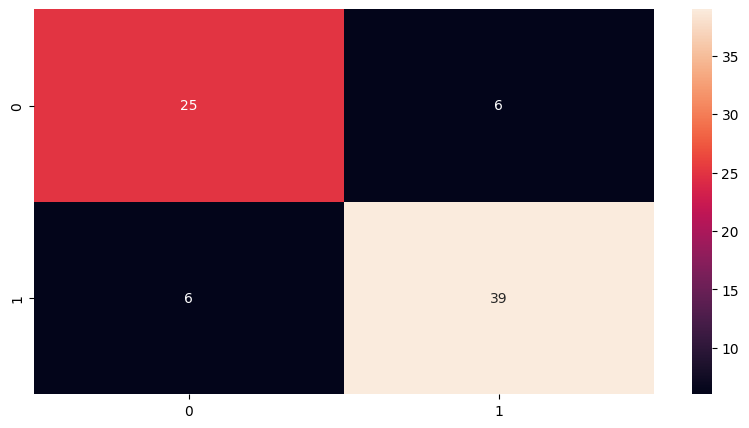

In [ ]:
import seaborn as sns
plt.figure(figsize = (10,5))
cm = confusion_matrix(y_test, pred2)
sns.heatmap(cm, annot=True, fmt = 'g')

In [ ]:
# @title ResNet50 Architechture
image_gen = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input)
train=image_gen.flow_from_dataframe(dataframe=train_set, x_col='filepaths',y_col='labels',
                                    target_size=(244,244),
                                    color_mode='rgb',
                                    class_mode="categorical",
                                    batch_size=32,
                                    shuffle=False)

test=image_gen.flow_from_dataframe(dataframe=test_images, x_col='filepaths',y_col='labels',
                                    target_size=(244,244),
                                    color_mode='rgb',
                                    class_mode="categorical",
                                    batch_size=32,
                                    shuffle=False)
val=image_gen.flow_from_dataframe(dataframe=val_set, x_col='filepaths',y_col='labels',
                                    target_size=(244,244),
                                    color_mode='rgb',
                                    class_mode="categorical",
                                    batch_size=32,
                                    shuffle=False)

Found 202 validated image filenames belonging to 2 classes.
Found 76 validated image filenames belonging to 2 classes.
Found 51 validated image filenames belonging to 2 classes.


In [ ]:
model=Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,2),strides=(1,1),activation='relu',padding='valid',input_shape=(244,244,3)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(rate=0.32))
model.add(Dense(64, activation='relu'))

model.add(Dense(2, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 242, 243, 32)      608       
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 121, 121, 32)      0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 468512)            0         
                                                                 
 dense_2 (Dense)             (None, 128)               59969664  
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                      

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
History=model.fit(train, validation_data=val, epochs=20, verbose=1, callbacks=[early_stopping])

Epoch 1/20
7/7 [==============================] - 18s 3s/step - loss: 855.9161 - accuracy: 0.6287 - val_loss: 375.7930 - val_accuracy: 0.6863
Epoch 2/20
7/7 [==============================] - 16s 2s/step - loss: 383.8471 - accuracy: 0.6634 - val_loss: 219.5300 - val_accuracy: 0.7451
Epoch 3/20
7/7 [==============================] - 16s 2s/step - loss: 152.8940 - accuracy: 0.7921 - val_loss: 98.9812 - val_accuracy: 0.7843
Epoch 4/20
7/7 [==============================] - 15s 2s/step - loss: 75.2774 - accuracy: 0.8119 - val_loss: 73.1361 - val_accuracy: 0.7647
Epoch 5/20
7/7 [==============================] - 16s 2s/step - loss: 26.5855 - accuracy: 0.9208 - val_loss: 43.5100 - val_accuracy: 0.7843
Epoch 6/20
7/7 [==============================] - 15s 2s/step - loss: 31.3337 - accuracy: 0.9208 - val_loss: 44.1448 - val_accuracy: 0.7843
Epoch 7/20
7/7 [==============================] - 15s 2s/step - loss: 15.2906 - accuracy: 0.9307 - val_loss: 59.6305 - val_accuracy: 0.7843
Epoch 8/20
7/7 

Text(0.5, 1.0, 'Training and Validation Accuracy')

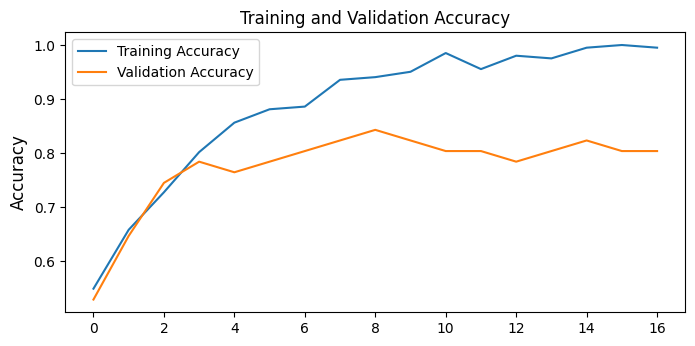

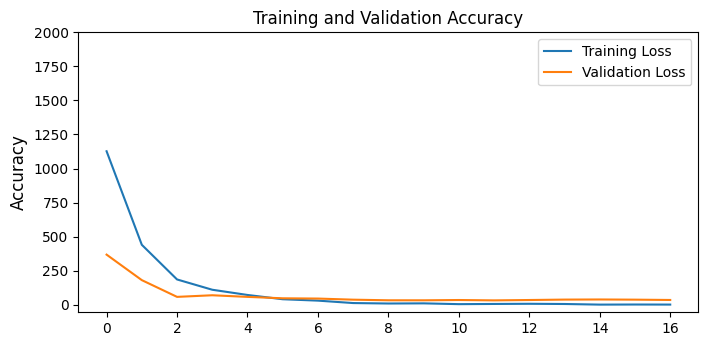

In [ ]:
#Accuracy curves
acc=History.history["accuracy"]
val_acc=History.history["val_accuracy"]

loss=History.history["loss"]
val_loss=History.history["val_loss"]

plt.figure(figsize=(8,8))
plt.subplot(2,1,1)

plt.plot(acc,label="Training Accuracy")
plt.plot(val_acc, label="Validation Accuracy")

plt.legend()
plt.ylabel("Accuracy", fontsize=12)
plt.title("Training and Validation Accuracy", fontsize=12)

#Loss Curves
plt.figure(figsize=(8,8))
plt.subplot(2,1,1)

plt.plot(loss,label="Training Loss")
plt.plot(val_loss, label="Validation Loss")

plt.legend()
plt.ylim([min(plt.ylim()),2000])
plt.ylabel("Accuracy", fontsize=12)
plt.title("Training and Validation Accuracy", fontsize=12)

In [ ]:
model.evaluate(test, verbose=1)
pred=model.predict(test)
pred=np.argmax(pred, axis=1)

labels=(train.class_indices)
labels=dict((v,k) for k,v in labels.items())
pred2=[labels[k] for k in pred]

3/3 [==============================] - 1s 289ms/step


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
y_test=test_images.labels
print(classification_report(y_test,pred2))
acc_3 = accuracy_score(y_test, pred2)*100
print("\nAccuracy of the model:",acc_3)

              precision    recall  f1-score   support

      absent       0.71      0.87      0.78        31
     present       0.89      0.76      0.82        45

    accuracy                           0.80        76
   macro avg       0.80      0.81      0.80        76
weighted avg       0.82      0.80      0.80        76


Accuracy of the model: 80.26315789473685


<Axes: >

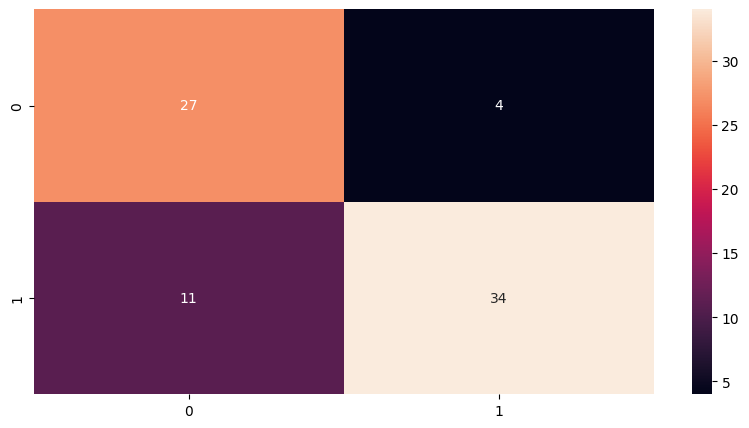

In [ ]:
import seaborn as sns
plt.figure(figsize = (10,5))
cm = confusion_matrix(y_test, pred2)
sns.heatmap(cm, annot=True, fmt = 'g')

In [ ]:
# @title VGG16 Architechture
image_gen = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)
train=image_gen.flow_from_dataframe(dataframe=train_set, x_col='filepaths',y_col='labels',
                                    target_size=(244,244),
                                    color_mode='rgb',
                                    class_mode="categorical",
                                    batch_size=32,
                                    shuffle=False)

test=image_gen.flow_from_dataframe(dataframe=test_images, x_col='filepaths',y_col='labels',
                                    target_size=(244,244),
                                    color_mode='rgb',
                                    class_mode="categorical",
                                    batch_size=32,
                                    shuffle=False)
val=image_gen.flow_from_dataframe(dataframe=val_set, x_col='filepaths',y_col='labels',
                                    target_size=(244,244),
                                    color_mode='rgb',
                                    class_mode="categorical",
                                    batch_size=32,
                                    shuffle=False)

Found 202 validated image filenames belonging to 2 classes.
Found 76 validated image filenames belonging to 2 classes.
Found 51 validated image filenames belonging to 2 classes.


In [ ]:
model=Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,2),strides=(1,1),activation='relu',padding='valid',input_shape=(244,244,3)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(rate=0.32))
model.add(Dense(64, activation='relu'))

model.add(Dense(2, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_25 (Conv2D)          (None, 242, 243, 32)      608       
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 121, 121, 32)      0         
 ng2D)                                                           
                                                                 
 flatten_4 (Flatten)         (None, 468512)            0         
                                                                 
 dense_11 (Dense)            (None, 128)               59969664  
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_12 (Dense)            (None, 64)                8256      
                                                      

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
History=model.fit(train, validation_data=val, epochs=20, verbose=1, callbacks=[early_stopping])

Epoch 1/20
7/7 [==============================] - 18s 2s/step - loss: 1453.8096 - accuracy: 0.5446 - val_loss: 572.3796 - val_accuracy: 0.6667
Epoch 2/20
7/7 [==============================] - 15s 2s/step - loss: 674.8173 - accuracy: 0.6535 - val_loss: 76.0643 - val_accuracy: 0.7843
Epoch 3/20
7/7 [==============================] - 15s 2s/step - loss: 287.7008 - accuracy: 0.6287 - val_loss: 187.1220 - val_accuracy: 0.5490
Epoch 4/20
7/7 [==============================] - 15s 2s/step - loss: 131.8798 - accuracy: 0.7723 - val_loss: 64.8087 - val_accuracy: 0.8039
Epoch 5/20
7/7 [==============================] - 16s 2s/step - loss: 75.8695 - accuracy: 0.8168 - val_loss: 64.4626 - val_accuracy: 0.6863
Epoch 6/20
7/7 [==============================] - 15s 2s/step - loss: 33.0691 - accuracy: 0.8812 - val_loss: 33.9164 - val_accuracy: 0.7451
Epoch 7/20
7/7 [==============================] - 15s 2s/step - loss: 27.6946 - accuracy: 0.8564 - val_loss: 19.2343 - val_accuracy: 0.7843
Epoch 8/20
7/

Text(0.5, 1.0, 'Training and Validation Accuracy')

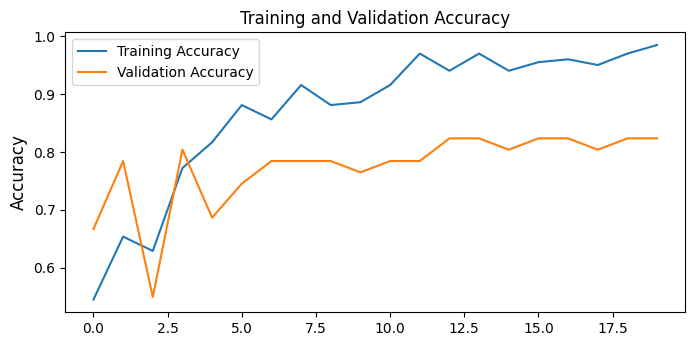

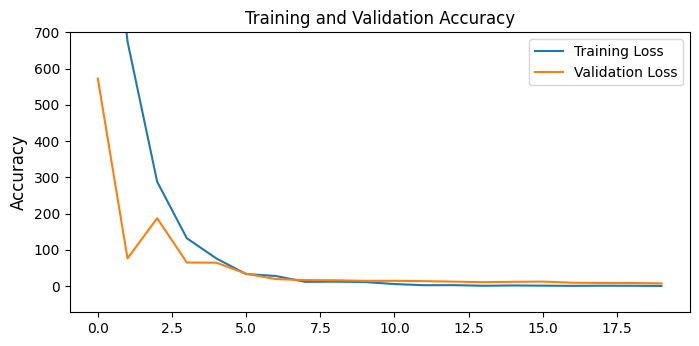

In [ ]:
#Accuracy curves
acc=History.history["accuracy"]
val_acc=History.history["val_accuracy"]

loss=History.history["loss"]
val_loss=History.history["val_loss"]

plt.figure(figsize=(8,8))
plt.subplot(2,1,1)

plt.plot(acc,label="Training Accuracy")
plt.plot(val_acc, label="Validation Accuracy")

plt.legend()
plt.ylabel("Accuracy", fontsize=12)
plt.title("Training and Validation Accuracy", fontsize=12)

#Loss Curves
plt.figure(figsize=(8,8))
plt.subplot(2,1,1)

plt.plot(loss,label="Training Loss")
plt.plot(val_loss, label="Validation Loss")

plt.legend()
plt.ylim([min(plt.ylim()),700])
plt.ylabel("Accuracy", fontsize=12)
plt.title("Training and Validation Accuracy", fontsize=12)

In [ ]:
model.evaluate(test, verbose=1)
pred=model.predict(test)
pred=np.argmax(pred, axis=1)

labels=(train.class_indices)
labels=dict((v,k) for k,v in labels.items())
pred2=[labels[k] for k in pred]

3/3 [==============================] - 2s 412ms/step


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
y_test=test_images.labels
print(classification_report(y_test,pred2))
acc_4 = accuracy_score(y_test, pred2)*100
print("\nAccuracy of the model:",acc_4)

              precision    recall  f1-score   support

      absent       0.92      0.77      0.84        31
     present       0.86      0.96      0.91        45

    accuracy                           0.88        76
   macro avg       0.89      0.86      0.87        76
weighted avg       0.89      0.88      0.88        76


Accuracy of the model: 88.1578947368421


<Axes: >

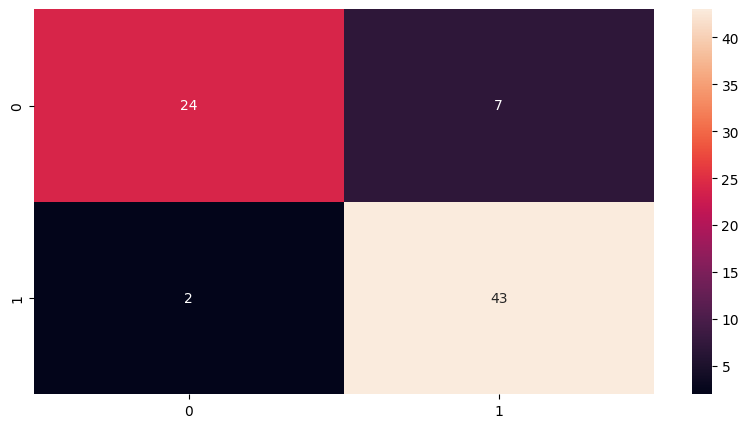

In [ ]:
import seaborn as sns
plt.figure(figsize = (10,5))
cm = confusion_matrix(y_test, pred2)
sns.heatmap(cm, annot=True, fmt = 'g')

In [ ]:
# Get the names of all layers in the model
layer_names = [layer.name for layer in model.layers]

# Print the layer names to inspect them
print(layer_names)

# Identify the correct name of the last convolutional layer
# Then use it in your function


['conv2d_25', 'max_pooling2d_10', 'flatten_4', 'dense_11', 'dropout_5', 'dense_12', 'dense_13']


In [ ]:
# @title Grad-Cam Segmentation
#Define Some Functions :
last_conv_layer_name = "max_pooling2d_10"

from tensorflow.keras.preprocessing import image

def get_img_array(img_path, size=(224, 224)):
    img = image.load_img(img_path, target_size=size)
    array = image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

import matplotlib.pyplot as plt
def make_gradcam_heatmap(img_array, model = model , last_conv_layer_name = last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )
    # Then, we compute the gradient of the top predicted class for our input image with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen) with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path, alpha=0.4, view=False):
    # Load the original image
    img = cv2.imread(img_path)

    # Resize the heatmap to match the original image size
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # Convert the heatmap to the RGB color space
    heatmap = np.uint8(255 * heatmap)

    # Apply the heatmap to the original image
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Combine the heatmap with the original image
    superimposed_img = heatmap * alpha + img * (1 - alpha)

    # Save the image with heatmap
    cv2.imwrite(cam_path, superimposed_img)

    # Display the image if view is True
    if view:
        plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()

def decode_predictions(preds):
    classes = ['no','yes']
    prediction = classes[np.argmax(preds)]
    return prediction

def make_prediction (img_path , model = model , last_conv_layer_name = last_conv_layer_name , campath = "cam.jpeg" , view = False):
    img = get_img_array(img_path = img_path)
    img_array = get_img_array(img_path, size=(244 , 244))
    preds = model.predict(img_array)
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    save_and_display_gradcam(img_path, heatmap , cam_path=campath , view = view)
    return [campath , decode_predictions(preds)]

1/1 [==============================] - 0s 136ms/step
yes


<ipython-input-51-3685303aa1ae>:50: RuntimeWarning: invalid value encountered in cast
  heatmap = np.uint8(255 * heatmap)


(-0.5, 466.5, 585.5, -0.5)

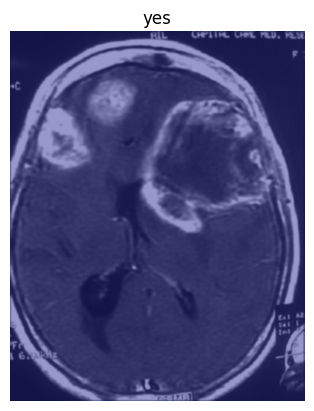

In [ ]:
from tensorflow import keras
from tensorflow.keras.preprocessing import image

def get_img_array(img_path, size=(224, 224)):
    img = image.load_img(img_path, target_size=size)
    array = image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array
address="/content/processed_images/validation/yes/Y180.jpg"
campath , prediction = make_prediction(address, campath="123.jpeg" , view = False)
print(prediction)
test_img = plt.imread(campath)
plt.imshow(test_img)
plt.title(prediction)
plt.axis("off")

1/1 [==============================] - 0s 50ms/step


<ipython-input-51-3685303aa1ae>:50: RuntimeWarning: invalid value encountered in cast
  heatmap = np.uint8(255 * heatmap)


1/1 [==============================] - 0s 52ms/step


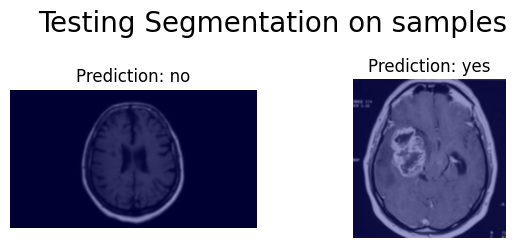

In [ ]:
# @title Trying segmentation on few random samples
# Define photos paths:

path_array = [
    "/content/processed_images/validation/no/11 no.jpg",
    '/content/processed_images/validation/yes/Y14.jpg'
]
fig = plt.figure(figsize=(7, 7))
fig.suptitle("Testing Segmentation on samples", fontsize=20)

# Assuming `train` is your DataFrameIterator object
# Iterate over the DataFrameIterator object
for i, (images, labels) in enumerate(train):
    if i >= len(path_array):
        break  # Break the loop if we have processed all paths in path_array

    ax = plt.subplot(3, 2, i + 1)
    campath, prediction = make_prediction(path_array[i], campath=f"{i}.jpeg")
    test_img = plt.imread(campath)
    plt.imshow(test_img)
    plt.title("Prediction: " + prediction)
    plt.axis("off")

    # Break the loop if we have processed all paths in path_array
    if i + 1 == len(path_array):
        break

plt.show()

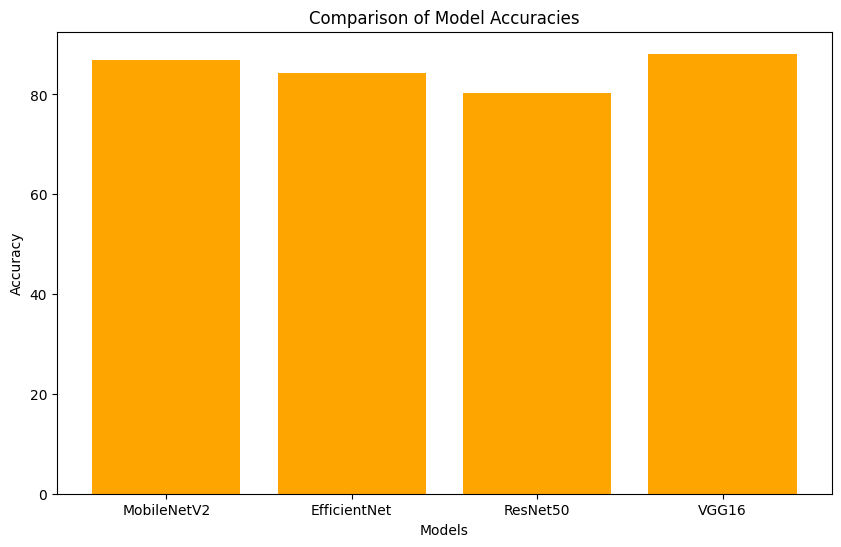

In [ ]:
import matplotlib.pyplot as plt

# Define model names and their corresponding accuracies
model_names = ['MobileNetV2', 'EfficientNet', 'ResNet50', 'VGG16']  # Example model names
accuracies = [acc_1, acc_2, acc_3, acc_4]  # Example accuracies corresponding to the models

# Create bar graph
plt.figure(figsize=(10, 6))
plt.bar(model_names, accuracies, color='orange')

# Add title and labels
plt.title('Comparison of Model Accuracies')
plt.xlabel('Models')
plt.ylabel('Accuracy')

# Show the plot
plt.show()